In [1]:
import wisps
import splat
import wisps.simulations as wispsim
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
import scipy.integrate as integrate
from tqdm import tqdm
import numpy as np
import wisps.simulations as wispsim
import numba
import bisect

%matplotlib inline

In [2]:
lf=wisps.LUMINOSITY_FUCTION
lfdes=wisps.DES_LUMINOSITY_FUCTION
maglimits=wisps.MAG_LIMITS

In [3]:
obs=pd.read_csv(wisps.OUTPUT_FILES+'//observation_log_with_limit.csv')

In [4]:
ras=obs['ra (deg)']
decs=obs['dec(deg)']

In [5]:
direcs=SkyCoord(ra=ras*u.deg, dec=decs*u.deg)

In [6]:
n=2
zscl=280

In [7]:
import splat

In [8]:
#custom_volume_correction(direcs[0],1., 100.)

In [9]:
import copy

In [10]:
@numba.jit
def custom_volume_correction(coordinate,dmin, dmax):
    nsamp=1000
    rho_function = ryan_density_function_l
    d = np.linspace(dmin,dmax,nsamp)
    rho = []
    c = splat.properCoordinates(coordinate)
    x,y,z = splat.xyz(c,distance=d,center='sun',unit=u.pc)
    r = (x**2+y**2)**0.5
    rho.append(rho_function(r.value, z.value))
    return float(integrate.trapz(rho*(d**2),x=d)/integrate.trapz(d**2,x=d))

In [11]:
@numba.jit
def convert_to_rz(ra, dec, dist):
    """
    returns r and z given a distance
    """
    newcoord=SkyCoord(ra=ra, dec=dec, distance=dist*u.pc)
    r=(newcoord.cartesian.x**2+newcoord.cartesian.y**2)**0.5
    z=newcoord.cartesian.z
    return r.to(u.pc).value, z.to(u.pc).value

@numba.vectorize
def ryan_density_function_l(r, z):
    
    """
    A l dwarfs density function beacsue numba doesn't allow vectorization with kwargs
    """
     
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    ##constants
    r0 = 8000 # radial offset from galactic center to Sun
    z0 = 25.  # vertical offset from galactic plane to Sun
    l1 = 2600. # radial length scale of exponential thin disk 
    h1 = 350.# vertical length scale of exponential thin disk 
    ftd = 0.12 # relative number of thick disk to thin disk star counts
    l2 = 3600. # radial length scale of exponential thin disk 
    h2 = 900. # vertical length scale of exponential thin disk 
    fh = 0.0051 # relative number of halo to thin disk star counts
    qh = 0.64 # halo axial ratio
    nh = 2.77 # halo power law index
    
    dens0=1.0
    
    thindens=dens0*np.exp(-abs(r-r0)/l1)
    halodens=1/(np.cosh(abs(z-z0)/h1)**2)
    
    return thindens*halodens


@numba.vectorize
def juric_density_function(r, z):
    
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    ##constants
    r0 = 8000 # radial offset from galactic center to Sun
    z0 = 25.  # vertical offset from galactic plane to Sun
    l1 = 2600. # radial length scale of exponential thin disk 
    h1 = 300.# vertical length scale of exponential thin disk 
    ftd = 0.12 # relative number of thick disk to thin disk star counts
    l2 = 3600. # radial length scale of exponential thin disk 
    h2 = 900. # vertical length scale of exponential thin disk 
    fh = 0.0051 # relative number of halo to thin disk star counts
    qh = 0.64 # halo axial ratio
    nh = 2.77 # halo power law index
    
    dens0=1.0
    
    thindens=dens0*np.exp(-abs(r-r0)/l1)*np.exp(-abs(z-z0)/h1)
    thickdens=dens0*np.exp(-abs(r-r0)/l2)*np.exp(-abs(z-z0)/h2)
    halodens= dens0*(((r0/(r**2+(z/qh)**2)**0.5))**nh)
    
    return thindens+ftd*thickdens+fh*halodens




In [12]:
zs=(np.logspace(-1, 3, 1000)+25.)
rs=abs(np.logspace(-1, 3, 1000)+8000)

In [13]:
juric=juric_density_function(rs, zs)

Text(0, 0.5, '$\\rho$ (z)')

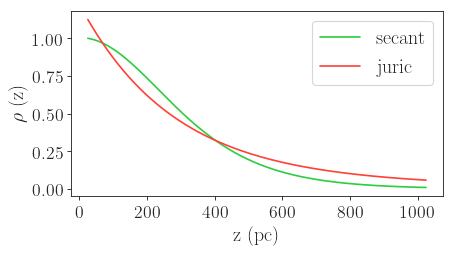

In [14]:
#plt.plot(zs, ryan_density_function_t(zs), label='ryan zscl=280 ', c='#0074D9')
plt.plot(zs, ryan_density_function_l(rs, zs), label='secant ', c='#2ECC40')
plt.plot(zs, juric, label='juric', c='#FF4136')
plt.legend()
plt.xlabel('z (pc)')
plt.ylabel(r'$\rho$ (z)')

In [15]:
def cdf(coord,  dmin, dmax):
    """
    The cumulative distribution function along the line of sight
    """
    @numba.vectorize("float64(float64)")
    def get_z_position(d):
        r, z=convert_to_rz(coord.ra, coord.dec, d)
        return z
    
    @numba.vectorize("float64(float64)")
    def get_volume(d):
        vc=custom_volume_correction(coord, dmin, d)
        return vc*(d**3)

    norm=(dmax)**3*custom_volume_correction(coord, dmin, dmax)
    dds=np.logspace(np.log10(dmin), np.log10(dmax), 5000)
    #zzs=get_z_position(dds)
    vs=get_volume(dds)
    return dds,vs/norm

def random_draw(dvals, cdfvals, dmax, dmin, nsample=1000):
    """
    randomly drawing x distances in a given direction
    """
    @numba.vectorize("int32(float64)")
    def invert_cdf(i):
        return bisect.bisect(cdfvals, i)
    x=np.random.rand(nsample)
    idx=invert_cdf(x)
    res= np.array(dvals)[idx-1]
    return res



In [16]:
dmin=5
dmax=10000

In [17]:
vals1, cdf1=cdf(direcs[0],  dmin, dmax)

In [18]:
juricp=wisps.OBSERVED_POINTINGS[0]

In [19]:
vals2, cdf2=juricp.cdf(dmin, dmax)

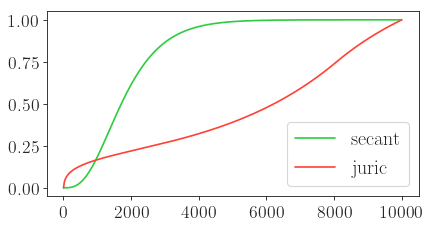

In [29]:
plt.plot(vals1, cdf1, label='secant ', c='#2ECC40')
plt.plot(vals2, cdf2,label='juric', c='#FF4136')
plt.legend()

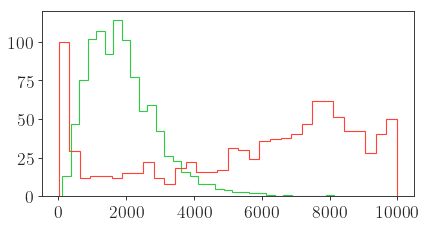

In [21]:
h=plt.hist(random_draw(vals1, cdf1, dmax, dmin, nsample=1000), bins=32, histtype='step',label='secant ', color='#2ECC40')
j=plt.hist(random_draw(vals2, cdf2, dmax, dmin, nsample=1000), histtype='step', bins=32,label='juric', color='#FF4136')
#plt.legend(loc='top right')

In [22]:

class Pointing(object):
    ## a pointing object making it easier to draw samples
    
    def __init__(self, **kwargs):
        #only input is the direction
        self.coord=kwargs.get('coord', None)
        self._samples={}
        self.survey=kwargs.get('survey', None)
        self.mag_limits=None
        self.dist_limits=None
        self.name=kwargs.get('name', None)
        self.volume=None
    
    def cdf(self,  dmin, dmax):
        """
        The cumulative distribution function along the line of sight
        """
        coord=self.coord
        @numba.vectorize("float64(float64)")
        def get_z_position(d):
            r, z=convert_to_rz(coord.ra, coord.dec, d)
            return z

        @numba.vectorize("float64(float64)")
        def get_volume(d):
            vc=custom_volume_correction(coord, dmin, d)
            return vc*(d**3)

        norm=(dmax)**3*custom_volume_correction(coord, dmin, dmax)
        dds=np.logspace(np.log10(dmin), np.log10(dmax), 5000)
        #zzs=get_z_position(dds)
        vs=get_volume(dds)
        return dds,vs/norm

    def compute_distance_limits(self):
        """
        computes distance limits based on limiting mags
        """
        rels=wisps.POLYNOMIAL_RELATIONS
        spgrid=np.arange(20, 38)
        if self.mag_limits is None:
            pass
        else:
            #use F140W for 3d-hst pointing and f110w for wisps
            pol=None
            maglmts=None
            if self.survey=='wisps':
                pol=rels['sp_F110W']
                maglmts= self.mag_limits['F110W']
            if self.survey=='hst3d':
                pol=rels['sp_F140W']
                maglmts=self.mag_limits['F140W']

            #compute asbmags using abolute mag relations
            absmags=pol(spgrid)
            relfaintmags=np.array([maglmts[0] for s in spgrid])
            relbrightmags=np.array([maglmts[1] for s in spgrid])
            
            #compute distances
            dmins=get_distance(absmags, relbrightmags)
            dmaxs=get_distance(absmags, relfaintmags)

            distances=np.array([dmaxs, dmins]).T

            self.dist_limits=dict(zip(spgrid, distances))
            #create a dictionary

    def computer_volume(self):
        """
        given area calculate the volume
        """
        volumes={}
        solid_angle=SOLID_ANGLE
        for k in self.dist_limits.keys():
             vc=spsim.volumeCorrection(self.coord,  self.dist_limits[k][1], self.dist_limits[k][0])
             volumes['vc_'+str(k)]=vc
             volumes[k]= vc*0.33333333333*(self.dist_limits[k][0]**3-self.dist_limits[k][1]**3)

        self.volume=volumes
    

    def random_draw(self,  dmax, dmin, nsample=1000):
        """
        randomly drawing x distances in a given direction
        """
        dvals, cdfvals=self.cdf(dmin, dmax)
        @numba.vectorize("int32(float64)")
        def invert_cdf(i):
            return bisect.bisect(cdfvals, i)
        x=np.random.rand(nsample)
        idx=invert_cdf(x)
        res= np.array(dvals)[idx-1]
        return res

    @property
    def samples(self):
        return self._samples
    
    def create_sample(self, nsample=1000):
        self._samples={}
        for k in  self.dist_limits.keys():
            #draw up to twice the distance limit
            self._samples[k]=self.random_draw( 2*self.dist_limits[k][0], self.dist_limits[k][1], nsample=nsample)

In [23]:
def get_survey(pointing):
    if pointing.startswith('par'):
        return 'wisps'
    else:
        return 'hst3d'

In [24]:
from wisps.utils.tools import get_distance
from wisps.simulations import SOLID_ANGLE
import splat.simulate as spsim
from functools import partial
import bisect

In [25]:
ras=obs['ra (deg)']
decs=obs['dec(deg)']
surveys=obs.pointing.apply(get_survey)

In [26]:
def make_pointing(ra, dec, survey, name):
    coord=SkyCoord(ra=ra*u.deg,dec=dec*u.deg )
    return Pointing(coord=coord, survey=survey, name=name)
pnts=[make_pointing(ra, dec, survey, name) for ra, dec, survey, name in zip(ras, decs, surveys, obs.pointing.values)]

In [27]:
#for pnt in tqdm(pnts):
#    pnt.mag_limits=maglimits[pnt.survey]
#    #print( pnt.survey)
#    pnt.compute_distance_limits()
##    pnt.computer_volume()
#    pnt.create_sample( nsample=1000)